# MNIST Dataset, Genetic Algorithms and Neural Networks

What is the MNIST dataset? Simply put, it is 70000 black and white images of handwritten digits.

Where is it available?

To begin, let's import the MNIST dataset.

For this notebook, we'll use scikit-learn and sklearn-deap for our computations, and plotly, seaborn and matplotlib for visualizations.

In [3]:
from sklearn.datasets import fetch_mldata
import tempfile
from six.moves import urllib
import pickle, os

if os.path.exists('mnist.p') == 0 or os.stat('mnist.p').st_size == 0:
    test_data_home = tempfile.mkdtemp()
    try:
        mnist = fetch_mldata('MNIST original',data_home=test_data_home)
    except:
        from scipy.io import loadmat
        mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
        mnist_path = "./mnist-original.mat"
        response = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_path, "wb") as f:
            content = response.read()
            f.write(content)
        mnist_raw = loadmat(mnist_path)
        mnist = {
            "data": mnist_raw["data"].T,
            "target": mnist_raw["label"][0],
            "COL_NAMES": ["label", "data"],
            "DESCR": "mldata.org dataset: mnist-original",
        }
    pickle.dump(mnist,open('mnist.p','wb'))
else:
    mnist = pickle.load(open('mnist.p','rb'))

Now that we've imported the data, let's explore what it looks like.

In [7]:
print(dict(zip(['n_samples/images','n_features/pixels'],mnist.data.shape)))

{'n_samples/images': 70000, 'n_features/pixels': 784}


There are 70000 images contained in the dataset, each with 784 pixels, containing intensity values from 1 to 255. The original images are actually 28 pixels x 28 px square images, so let's reshape one of these images/samples into 28px by 28px and plot a heatmap of this:

In [8]:
import seaborn as sns, matplotlib.pyplot as plt, numpy as np, pandas as pd

(28, 28)


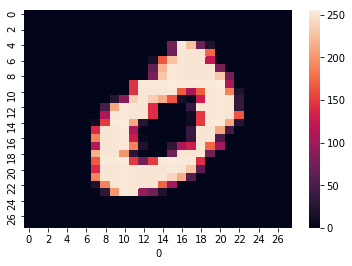

In [9]:
# image 3, a 1x728 dimensional vector of intensity values
image_heatmap_data = mnist.data[3,:].reshape((28,28))
print(image_heatmap_data.shape)

plt.figure()
sns.heatmap(image_heatmap_data)
plt.xlabel(str(int(mnist.target[3])))
plt.show()

Now let's'plot the first 49 digits:

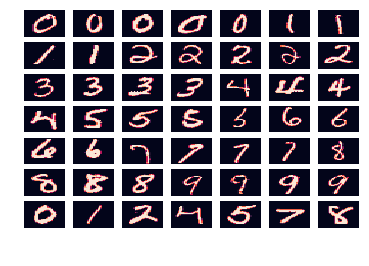

In [29]:
idxs = np.linspace(0,mnist.data.shape[0],50).astype(int)
for i in range(49):
    plt.subplot(7,7,i+1)
    plt.axis('off')
    sns.heatmap(mnist.data[idxs[i],:].reshape((28,28)),cbar=False)
    plt.xlabel(str(int(mnist.target[idxs[i]])))
    
plt.show()

There you go, the MNIST dataset. 70000 images that were originally 28px by 28px images that were turned into 728 px vectors. The images were flattened, and so we have a 70000 by 728 sample by feature matrix, and we can access a digit by loading a particular row of the matrix.

So let's do some machine learning. Let's train a neural network to recognize handwritten digits. First, randomize all of our digits.

In [10]:
shuffled = np.arange(mnist.data.shape[0])
np.random.shuffle(shuffled)
data = mnist.data[shuffled,:]
labels = mnist.target[shuffled]

Then, split them into a training set and testing set. We will train our neural network to recognize these digits, and then test the accuracy on our test set. Consult these videos and text for some explanations:
* https://www.youtube.com/watch?v=aircAruvnKk
* https://www.youtube.com/watch?v=rEDzUT3ymw4
* http://neuralnetworksanddeeplearning.com/chap1.html
* http://natureofcode.com/book/chapter-10-neural-networks/

For this example we will use a multilayer perceptron (MLP):

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,labels,test_size=0.33, random_state=42)

67% of the digits and labels are devoted to training the data, while 33% of the digits are devoted to testing. We now initialize the MLPClassifier, which we will train using our training set X_train, X_test:

In [26]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(20,20),activation='tanh',learning_rate='constant')
MLP.fit(X_train,y_train)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [27]:
# Code shout out to Oli Blum: https://stackoverflow.com/questions/29888233/how-to-visualize-a-neural-network
from math import cos, sin, atan


class Neuron():
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def draw(self, neuron_radius):
        circle = plt.Circle((self.x, self.y), radius=neuron_radius, fill=False)
        plt.gca().add_patch(circle)


class Layer():
    def __init__(self, network, number_of_neurons, number_of_neurons_in_widest_layer):
        self.vertical_distance_between_layers = 6
        self.horizontal_distance_between_neurons = 2
        self.neuron_radius = 0.5
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.previous_layer = self.__get_previous_layer(network)
        self.y = self.__calculate_layer_y_position()
        self.neurons = self.__intialise_neurons(number_of_neurons)

    def __intialise_neurons(self, number_of_neurons):
        neurons = []
        x = self.__calculate_left_margin_so_layer_is_centered(number_of_neurons)
        for iteration in range(number_of_neurons):
            neuron = Neuron(x, self.y)
            neurons.append(neuron)
            x += self.horizontal_distance_between_neurons
        return neurons

    def __calculate_left_margin_so_layer_is_centered(self, number_of_neurons):
        return self.horizontal_distance_between_neurons * (self.number_of_neurons_in_widest_layer - number_of_neurons) / 2

    def __calculate_layer_y_position(self):
        if self.previous_layer:
            return self.previous_layer.y + self.vertical_distance_between_layers
        else:
            return 0

    def __get_previous_layer(self, network):
        if len(network.layers) > 0:
            return network.layers[-1]
        else:
            return None

    def __line_between_two_neurons(self, neuron1, neuron2):
        angle = atan((neuron2.x - neuron1.x) / float(neuron2.y - neuron1.y))
        x_adjustment = self.neuron_radius * sin(angle)
        y_adjustment = self.neuron_radius * cos(angle)
        line = plt.Line2D((neuron1.x - x_adjustment, neuron2.x + x_adjustment), (neuron1.y - y_adjustment, neuron2.y + y_adjustment))
        plt.gca().add_line(line)

    def draw(self, layerType=0):
        for neuron in self.neurons:
            neuron.draw( self.neuron_radius )
            if self.previous_layer:
                for previous_layer_neuron in self.previous_layer.neurons:
                    self.__line_between_two_neurons(neuron, previous_layer_neuron)
        # write Text
        x_text = self.number_of_neurons_in_widest_layer * self.horizontal_distance_between_neurons
        if layerType == 0:
            plt.text(x_text, self.y, 'Input Layer', fontsize = 12)
        elif layerType == -1:
            plt.text(x_text, self.y, 'Output Layer', fontsize = 12)
        else:
            plt.text(x_text, self.y, 'Hidden Layer '+str(layerType), fontsize = 12)

class NeuralNetwork():
    def __init__(self, number_of_neurons_in_widest_layer):
        self.number_of_neurons_in_widest_layer = number_of_neurons_in_widest_layer
        self.layers = []
        self.layertype = 0

    def add_layer(self, number_of_neurons ):
        layer = Layer(self, number_of_neurons, self.number_of_neurons_in_widest_layer)
        self.layers.append(layer)

    def draw(self):
        plt.figure()
        for i in range( len(self.layers) ):
            layer = self.layers[i]
            if i == len(self.layers)-1:
                i = -1
            layer.draw( i )
        plt.axis('scaled')
        plt.axis('off')
        plt.title( 'Neural Network architecture', fontsize=15 )
        plt.show()

class DrawNN():
    def __init__( self, neural_network ):
        self.neural_network = neural_network

    def draw( self ):
        widest_layer = max( self.neural_network )
        network = NeuralNetwork( widest_layer )
        for l in self.neural_network:
            network.add_layer(l)
        network.draw()

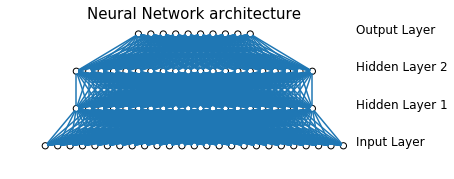

In [30]:
network = DrawNN( [25, 20 , 20 , 10] )
network.draw()

The input layer has 728 elements, which we scaled down to 25 in the above diagram, this feeds into 20 neurons in the hidden layer 1, which serves as the inputs to a 20-neuron hidden layer 2, which are then fed into the 10-dimensional output layer. The classifier essentially finds the index of that output with the maximum value and declares that the digit it has been classified as. As we train the model, the error is reduced via some gradient descent method, and each node/neuron is some activation function, in this case the hyperbolic tangent, while each edge represents a weight W_i. The goal of this neural network is to change the weights W and biases b such that the error between what is found in the output layer versus the tru labels from y_train is minimized.

We then test our test data set by using the model to predict the correct digit. We compare this against the ground truth.

In [35]:
y_predicted = MLP.predict(X_test)
print(y_predicted)
print(y_test)
accuracy = sum(y_test == y_predicted)/float(len(y_test))
print(accuracy)

[ 3.  3.  9. ...,  3.  8.  3.]
[ 5.  3.  9. ...,  3.  8.  3.]
0.902034632035


We see that this network attains ~90% accuracy, which is actually pretty good.

In my next example, I'll show you how you can visualize these digits in 3 dimensions. We'll plot these digits using PCA and TSNE, and show how the predicted digits compare to what was actually written.

TSNE EXAMPLE IS IN DEVELOPMENT!!!

Now that we've given a brief intro to neural networks, let's discuss Genetic Algorithms!